In [5]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import mdtraj
plt.rc('font', family='serif')

In [6]:
# we want to find the atoms with the fastest fluctuations when optimally aligned, and then
# deemphasize them in a weighted RMSD Mahalanobis distance
# the result will be a vector of length N where N is the number of atoms in the molecule
# which will be written on the diagonal of an NxN matrix and multiplied into RMSD or Binet-Cauchy computations

In [7]:
from mdtraj.geometry import alignment

In [8]:
npr.seed(0)
X = npr.randn(100,3)
Y = X.dot(np.diag([1,2,1]))

In [9]:
def compute_atomwise_deviation_xyz(X_xyz,Y_xyz):
    X_prime = alignment.transform(X_xyz, Y_xyz)
    delta = X_prime - Y_xyz
    deviation = ((delta**2).sum(1))**0.5
    return deviation

def compute_atomwise_deviation(X,Y):
    return compute_atomwise_deviation_xyz(X.xyz[0],Y.xyz[0])

In [10]:
from msmbuilder.example_datasets import FsPeptide
dataset = FsPeptide().get()
fs_trajectories = dataset.trajectories
fs_t = fs_trajectories[0]

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [16]:
dataset.DESCR

'This dataset consists of 28 molecular dynamics trajectories of Fs peptide\n(Ace-A_5(AAARA)_3A-NME), a widely studied model system for protein folding.\nEach trajectory is 500 ns in length, and saved at a 50 ps time interval (14\nus aggegrate sampling). The simulations were performed using the AMBER99SB-ILDN\nforce field with GBSA-OBC implicit solvent at 300K, starting from randomly\nsampled conformations from an initial 400K unfolding simulation. The\nsimulations were performed with OpenMM 6.0.1.\n\nThe dataset, including the script used to generate the dataset\nis available on figshare at\n\nhttp://dx.doi.org/10.6084/m9.figshare.1030363\n'

In [ ]:
from simtk.u

In [11]:
compute_atomwise_deviation(fs_t[0],fs_t[1])

array([ 0.2736049 ,  0.31249315,  0.45631918,  0.56824243,  0.39038154,
        0.61741918,  0.12921417,  0.1910737 ,  0.1078198 ,  0.19963315,
        0.22519577,  0.19590892,  0.32110301,  0.27312964,  0.17915575,
        0.29011145,  0.21170364,  0.22641671,  0.28967503,  0.37695208,
        0.38686621,  0.46105647,  0.36235049,  0.42556977,  0.21474868,
        0.30348644,  0.07641894,  0.0773477 ,  0.0979026 ,  0.12217472,
        0.26349691,  0.41632593,  0.21077415,  0.34280497,  0.12900214,
        0.22966817,  0.15264788,  0.18641464,  0.22280852,  0.28097129,
        0.31960946,  0.40531895,  0.4608331 ,  0.24450701,  0.13093749,
        0.13449605,  0.11552193,  0.18730059,  0.07964478,  0.05096602,
        0.1790981 ,  0.21442762,  0.25200829,  0.15901408,  0.10622683,
        0.12826923,  0.14088871,  0.15214884,  0.13704404,  0.13312384,
        0.14975192,  0.16903874,  0.2071446 ,  0.28365952,  0.137787  ,
        0.13306697,  0.14059778,  0.15959011,  0.14029184,  0.12

In [17]:
tau=20
n_frames=len(fs_t)-tau
n_atoms = fs_t.n_atoms
atomwise_deviations=np.zeros((n_frames,n_atoms))
for i in range(n_frames):
    atomwise_deviations[i] = compute_atomwise_deviation(fs_t[i],fs_t[i+tau])

In [13]:
atomwise_deviations.shape

(9000, 264)

In [15]:
fs

NameError: name 'fs' is not defined

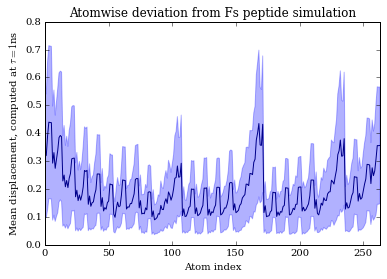

In [27]:
mean = np.mean(atomwise_deviations,0)
stdev = np.std(atomwise_deviations,0)
plt.plot(mean,c='darkblue')
#plt.plot(mean+stdev,c='blue',linestyle='--')
#plt.plot(mean-stdev,c='blue',linestyle='--')
plt.fill_between(range(len(mean)),mean-stdev,mean+stdev,color='blue',alpha=0.3)
plt.xlabel('Atom index')
plt.ylabel(r'Mean displacement, computed at $\tau=1$ns')
plt.title('Atomwise deviation from Fs peptide simulation')
plt.xlim(0,263)
plt.savefig('atomwise_deviation.pdf')

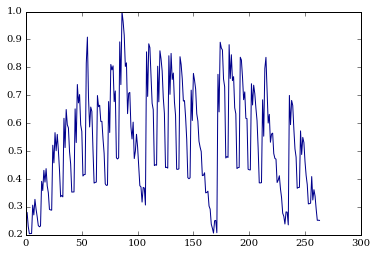

In [31]:
plt.plot((1/mean) / np.max(1/mean),c='darkblue')
plt

In [38]:
from msmbuilder.cluster import MiniBatchKMedoids
kmed = MiniBatchKMedoids(metric='rmsd')
kmed.fit(fs_trajectories)

MiniBatchKMedoids(batch_size=100, max_iter=5, max_no_improvement=10,
         metric='rmsd', n_clusters=8, random_state=None)

In [39]:
clustered = kmed.transform(fs_trajectories)

In [41]:
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel()
msm.fit(clustered)

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff=1.0, lag_time=1, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [42]:
msm.score_

7.1591566439116132

In [44]:
from msmbuilder.featurizer import DihedralFeaturizer
dih_model = DihedralFeaturizer()
dih_traj = dih_model.fit_transform(fs_trajectories)

In [48]:
kmed = MiniBatchKMedoids()
clustered = kmed.fit_transform(dih_traj)
msm = MarkovStateModel()
msm.fit(clustered)
msm.score_

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


5.6936650906587127

In [61]:
from msmbuilder.decomposition import tICA

tica = tICA(lag_time=10,weighted_transform=True)
tica_traj = tica.fit_transform(dih_traj)

kmed = MiniBatchKMedoids()
clustered = kmed.fit_transform(tica_traj)
msm = MarkovStateModel()
msm.fit(clustered)
msm.score_

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


7.6221528864894612

In [63]:
trajectory = fs_trajectories[0]

In [102]:
def wrmsd_dmat(trajectory,weights):
    dmat = np.zeros((len(trajectory),len(trajectory)))
    N = trajectory.n_atoms
    for i in range(1,len(dmat)):
        # align everything to the current "pivot" element
        trajectory.superpose(trajectory,i)
        
        # compute atomwise squared deviations
        atomwise_deviations = ((trajectory[:i].xyz - trajectory[i].xyz)**2).sum(-1)
        
        # dot with a weight vector and divide by the number of atoms
        weighted_rmsd = atomwise_deviations.dot(weights) / N
        
        # assign to the lower-left half of the distance matrix
        dmat[i,:i] = weighted_rmsd
    
    # return a full distance matrix
    return dmat + dmat.T

In [114]:
trajectory = fs_trajectories[0][::20]
len(trajectory)

500

In [115]:
dmat = wrmsd_dmat(trajectory,np.ones(trajectory.n_atoms))

In [125]:
%timeit dmat = wrmsd_dmat(trajectory,np.ones(trajectory.n_atoms))

1 loops, best of 3: 5.56 s per loop


In [116]:
dmat.shape

(500, 500)

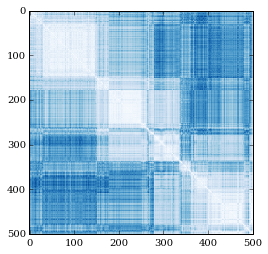

In [117]:
plt.imshow(dmat,interpolation='none',cmap='Blues')

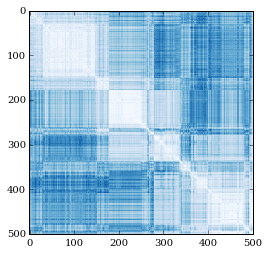

In [118]:
dmat_1 = wrmsd_dmat(trajectory,mean)
plt.imshow(dmat_1,interpolation='none',cmap='Blues')

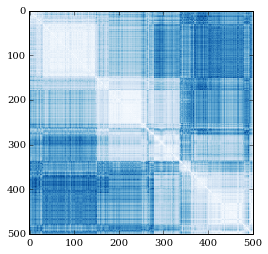

In [119]:
dmat_2 = wrmsd_dmat(trajectory,1/mean)
plt.imshow(dmat_2,interpolation='none',cmap='Blues')

In [121]:
from sklearn.manifold import MDS

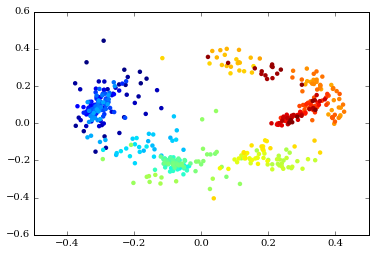

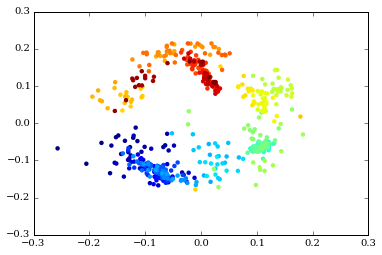

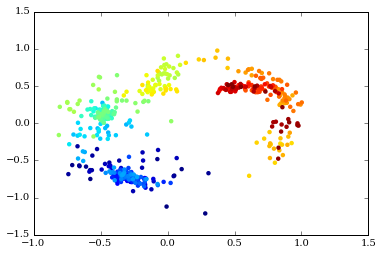

In [124]:
# unweighted
mds = MDS(dissimilarity='precomputed')
X = mds.fit_transform(dmat)
plt.scatter(X[:,0],X[:,1],linewidths=0,c=range(len(X)))

# weighted (dumbly)
plt.figure()
mds = MDS(dissimilarity='precomputed')
X = mds.fit_transform(dmat_1)
plt.scatter(X[:,0],X[:,1],linewidths=0,c=range(len(X)))

# weighted (cleverly)
plt.figure()
mds = MDS(dissimilarity='precomputed')
X = mds.fit_transform(dmat_2)
plt.scatter(X[:,0],X[:,1],linewidths=0,c=range(len(X)))

In [90]:
deviations = (trajectory[:1000].xyz - trajectory[1].xyz).sum(-1)


deviations.shape,deviations.sum(1).shape

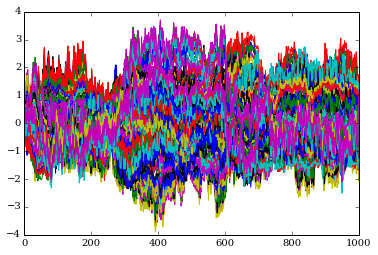

In [91]:
plt.plot(deviations);

In [83]:
weights = np.ones(trajectory.n_atoms)
weights.shape

(264,)

In [85]:
deviations.dot(weights).shape

(10,)

In [ ]:
class AltMiniBatchKMedoids(MiniBatchKMedoids):
    
    ''' redefines fit and transform to also allow weighted rmsd instead of just 'rmsd' 
    
    metric = {any metric accepted by minibatchkmedoids, ('wrmsd', np.ndarray of weights)}
    
    going to do this by replacing the calls to libdistance.pdist and libdistance.pd
    
    better way: augment libdistance to accept callables instead of just strings'''
    

    
    def fit(self, X, y=None):
        n_samples = len(X)
        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        n_iter = int(self.max_iter * n_batches)
        random_state = check_random_state(self.random_state)

        cluster_ids_ = random_state.random_integers(
            low=0, high=n_samples - 1, size=self.n_clusters)
        labels_ = random_state.random_integers(
            low=0, high=self.n_clusters - 1, size=n_samples)

        n_iters_no_improvement = 0
        for kk in range(n_iter):
            # each minibatch includes the random indices AND the
            # current cluster centers
            minibatch_indices = np.concatenate([
                cluster_ids_,
                random_state.random_integers(
                    0, n_samples - 1, self.batch_size),
            ])
            X_indices=np.array(minibatch_indices, dtype=np.intp)
            
            if metric[0]=='wmrsd':
                dmat = wrmsd_dmat(X[X_indices],weights=metric[1])
            else:
                dmat = libdistance.pdist(X, metric=self.metric, X_indices=X_indices)
            minibatch_labels = np.array(np.concatenate([
                np.arange(self.n_clusters),
                labels_[minibatch_indices[self.n_clusters:]]
            ]), dtype=np.intp)

            ids, intertia, _ = _kmedoids.kmedoids(
                self.n_clusters, dmat, 0, minibatch_labels,
                random_state=random_state)
            minibatch_labels, m = _kmedoids.contigify_ids(ids)

            # Copy back the new cluster_ids_ for the centers
            minibatch_cluster_ids = np.array(
                sorted(m.items(), key=itemgetter(1)))[:, 0]
            cluster_ids_ = minibatch_indices[minibatch_cluster_ids]

            # Copy back the new labels for the elements
            n_changed = np.sum(labels_[minibatch_indices] != minibatch_labels)
            if n_changed == 0:
                n_iters_no_improvement += 1
            else:
                labels_[minibatch_indices] = minibatch_labels
                n_iters_no_improvement = 0
            if n_iters_no_improvement >= self.max_no_improvement:
                break

        self.cluster_ids_ = cluster_ids_
        self.cluster_centers_ = X[cluster_ids_]
        self.labels_, self.inertia_ = libdistance.assign_nearest(
            X, self.cluster_centers_, metric=self.metric)
        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.
        In the vector quantization literature, `cluster_centers_` is called
        the code book and each value returned by `predict` is the index of
        the closest code in the code book.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            New data to predict.
        Returns
        -------
        Y : array, shape [n_samples,]
            Index of the closest center each sample belongs to.
        """
        
        
        labels, _ = libdistance.assign_nearest(
            X, self.cluster_centers_, metric=self.metric)
        return labels

In [18]:
import mdtraj as md
md.

In [8]:
atomwise_deviations = dict()
for tau in list(range(1,10)) + [25,50,100]:
    print(tau)
    n_frames=len(fs_t)-tau
    n_atoms = fs_t[0].n_atoms
    atomwise_deviations[tau]=np.zeros((n_frames,n_atoms))
    for i in range(n_frames):
        atomwise_deviations[tau][i] = compute_atomwise_deviation(fs_t[i],fs_t[i+tau])

1
2
3


KeyboardInterrupt: 

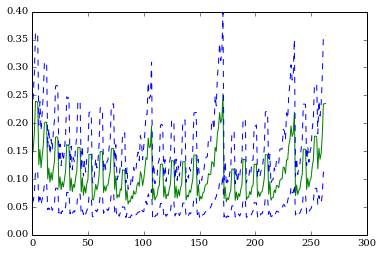

In [99]:
mean = np.mean(atomwise_deviations[1],0)
stdev = np.std(atomwise_deviations[1],0)
plt.plot(mean,c='green')
plt.plot(mean+stdev,c='blue',linestyle='--')
plt.plot(mean-stdev,c='blue',linestyle='--')

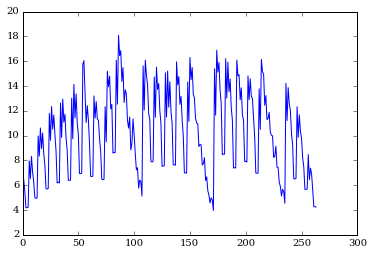

In [100]:
plt.plot(1.0/mean)

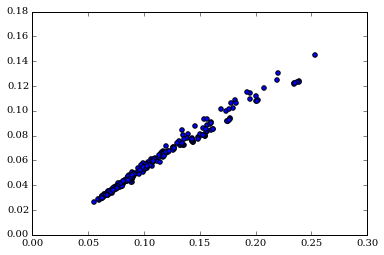

In [101]:
plt.scatter(mean,stdev)

In [102]:
means = np.array([np.mean(d,0) for d in atomwise_deviations.values()]).T

In [ ]:
plt.plot(np.arange(len(means))+1,means[:,0],label='Lag-time: 50ps');
#plt.plot(np.arange(len(means))+1,means[:,-1],label='Lag-time: 5000ps');
plt.xlabel('Residue #')
plt.ylabel('Mean distance (nm)')
plt.title('Fs Peptide')
plt.legend(loc='best',frameon=False)

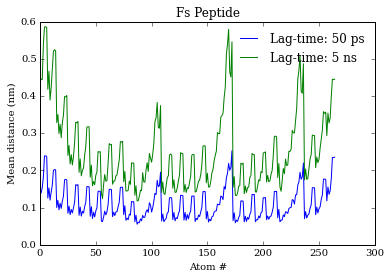

In [107]:
plt.plot(np.arange(len(means))+1,means[:,0],label='Lag-time: 50 ps');
plt.plot(np.arange(len(means))+1,means[:,-1],label='Lag-time: 5 ns');
plt.xlabel('Atom #')
plt.ylabel('Mean distance (nm)')
plt.title('Fs Peptide')
plt.legend(loc='best',frameon=False)

In [ ]:
fs_trajectories

In [75]:
s = sorted(np.arange(len(means)),key=lambda i:means[i][-1])

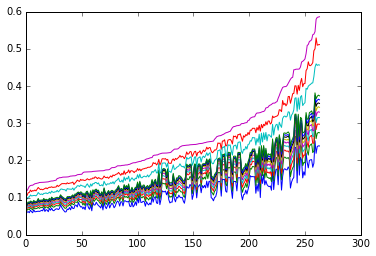

In [79]:
plt.plot(means[s]);
plt.xlabel('Atom (sorted)')

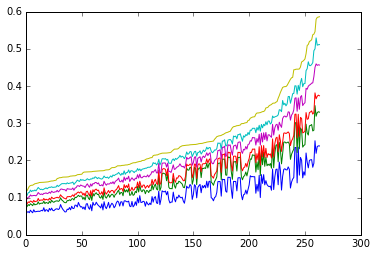

In [85]:
plt.plot(means[:,[0,4,8,9,10,11]][s]);

In [80]:
means.shape

(264, 12)

In [84]:
means[:,[0,4,8,9,10,11]].shape

(264, 6)

In [90]:
print(FsPeptide.description())

This dataset consists of 28 molecular dynamics trajectories of Fs peptide
(Ace-A_5(AAARA)_3A-NME), a widely studied model system for protein folding.
Each trajectory is 500 ns in length, and saved at a 50 ps time interval (14
us aggegrate sampling). The simulations were performed using the AMBER99SB-ILDN
force field with GBSA-OBC implicit solvent at 300K, starting from randomly
sampled conformations from an initial 400K unfolding simulation. The
simulations were performed with OpenMM 6.0.1.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1030363



In [127]:
atoms,_ = fs_t.topology.to_dataframe()
atoms.element

0      C
1      O
2      C
3      H
4      H
5      H
6      N
7      H
8      C
9      H
10     C
11     H
12     H
13     H
14     C
15     O
16     N
17     H
18     C
19     H
20     C
21     H
22     H
23     H
24     C
25     O
26     N
27     H
28     C
29     H
      ..
234    H
235    H
236    C
237    O
238    N
239    H
240    C
241    H
242    C
243    H
244    H
245    H
246    C
247    O
248    N
249    H
250    C
251    H
252    C
253    H
254    H
255    H
256    C
257    O
258    N
259    H
260    C
261    H
262    H
263    H
Name: element, dtype: object

In [129]:
a = np.array(atoms.element)
a

array(['C', 'O', 'C', 'H', 'H', 'H', 'N', 'H', 'C', 'H', 'C', 'H', 'H',
       'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'O',
       'N', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'O', 'N', 'H', 'C',
       'H', 'C', 'H', 'H', 'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H',
       'H', 'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C',
       'O', 'N', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'O', 'N', 'H',
       'C', 'H', 'C', 'H', 'H', 'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C',
       'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'N', 'H', 'C', 'N', 'H',
       'H', 'N', 'H', 'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H', 'H',
       'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'O',
       'N', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'O', 'N', 'H', 'C',
       'H', 'C', 'H', 'H', 'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H',
       'H', 'C', 'H', 'H', 'C', 'H', 'H', 'N', 'H', 'C', 'N', 'H', 'H',
       'N', 'H', 'H', 'C', 'O', 'N', 'H', 'C', 'H', 'C', 'H', 'H

In [136]:
atom_color_dict = {'C':0,'H':1,'O':2,'N':3}
atom_colors = np.array([atom_color_dict[e] for e in a])

<matplotlib.colorbar.Colorbar instance at 0x12a023a70>

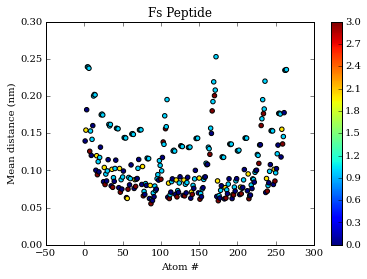

In [139]:
plt.scatter(np.arange(len(means))+1,means[:,0],#label='Lag-time: 50 ps',
            c=atom_colors);
plt.xlabel('Atom #')
plt.ylabel('Mean distance (nm)')
plt.title('Fs Peptide')
plt.colorbar()
#plt.legend(loc='best',frameon=False)

In [141]:
m = means[:,0]

In [142]:
m.shape

(264,)

In [144]:
for atom in atom_color_dict:
    print(atom,np.mean(m[a==atom]))

('H', 0.13019366434256116)
('C', 0.090030580933748994)
('O', 0.094697414488768061)
('N', 0.096386607212414266)


In [190]:
weights = 1/means[:,0]
weights.shape

(264,)

In [150]:
from msmbuilder.cluster import MiniBatchKMedoids

In [152]:
kmedoids = MiniBatchKMedoids(metric='rmsd')

In [166]:
X_ = kmedoids.fit_transform(fs_t)

In [167]:
X_ = np.array(X_)[:,0]
X_.shape

(10000,)

In [168]:
from msmbuilder import msm
m = msm.MarkovStateModel()

In [169]:
m.fit(X_)

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff=1.0, lag_time=1, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [176]:
print(m.summarize())

Markov state model
------------------
Lag time         : 1
Reversible type  : mle
Ergodic cutoff   : 1.0
Prior counts     : 0

Number of states : 8
Number of nonzero entries in counts matrix : 51 (79.6875%)
Nonzero counts matrix entries:
    Min.   : 1.0
    1st Qu.: 3.0
    Median : 9.0
    Mean   : 196.1
    3rd Qu.: 35.0
    Max.   : 2777.0

Total transition counts :
    9999.0 counts
Total transition counts / lag_time:
    9999.0 units
Timescales:
    [45.39, 36.32, 19.03, 15.16, 4.74, 3.62, 2.12]  units



<matplotlib.colorbar.Colorbar instance at 0x12ba8a998>

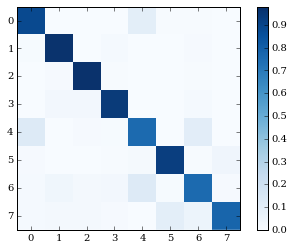

In [173]:
plt.imshow(m.transmat_,interpolation='none',cmap='Blues')
plt.colorbar()

In [177]:
n=5000
t = fs_t[:n]

In [180]:
rmsd = np.zeros((n,n))
for i in range(n):
    rmsd[i,i:] = mdtraj.rmsd(t[i:n],t[i])

In [206]:
rmsd = rmsd + rmsd.T

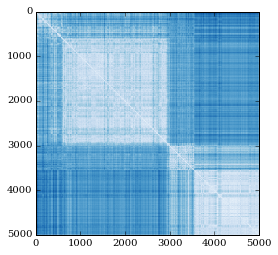

In [207]:
plt.imshow(rmsd,interpolation='none',cmap='Blues')

In [201]:
def wRMSD(X,Y,w='unweighted'):
    dev = compute_atomwise_deviation(X,Y)
    if w == 'unweighted':
        wdev = sum(dev)
    else:
        wdev = w.dot(dev)
    
    return np.sqrt(wdev) / len(X.xyz.T)

In [202]:
wRMSD(t[0],t[1])

2.1978461661178819

In [204]:
wRMSD(t[0],t[1],weights)

6.5107794040569225

In [209]:
wrmsd_mat = np.zeros((n,n))
for i in range(len(t)):
    for j in range(i):
        wrmsd_mat[i,j] = wRMSD(t[i],t[j],weights)
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510


KeyboardInterrupt: 

In [222]:
wrmsd_subset = wrmsd_mat[:500,:500] + wrmsd_mat[:500,:500].T
rmsd_subset = rmsd[:500,:500]

<matplotlib.colorbar.Colorbar instance at 0x1330047e8>

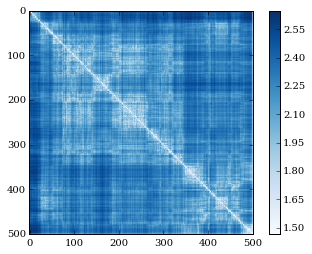

In [230]:
plt.imshow(np.log(wrmsd_subset),cmap='Blues',interpolation='none')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x12baa1bd8>

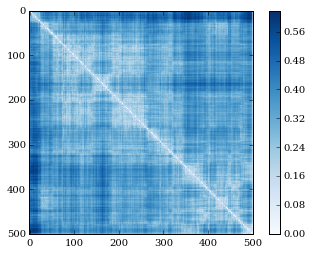

In [232]:
plt.imshow(np.log(rmsd_subset+1),cmap='Blues',interpolation='none')
plt.colorbar()

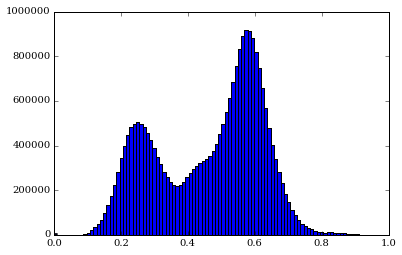

In [220]:
plt.hist(rmsd.flatten(),bins=100);

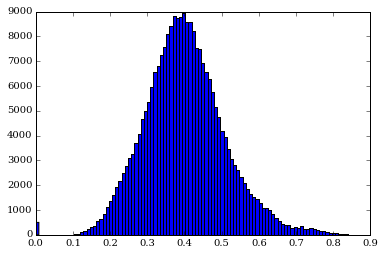

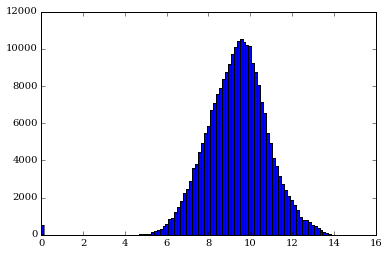

In [227]:
plt.hist(rmsd_subset.flatten(),bins=100);
plt.figure()
plt.hist(wrmsd_subset.flatten(),bins=100);

In [203]:
dev = compute_atomwise_deviation(t[0],t[1])
dev.shape

(264,)

In [ ]:
mdtraj.rmsd(

In [248]:
from msmbuilder import featurizer
rpf = featurizer.RawPositionsFeaturizer()
rpft = rpf.fit_transform(t.center_coordinates())

In [250]:
rpft[0].shape

(1, 792)

In [253]:
np.reshape(rpft,(len(t),n_atoms,3)).shape

(5000, 264, 3)

In [255]:
rpft = np.reshape(rpft,(len(t),n_atoms,3))

In [257]:
dev_mat = np.zeros((n,n,n_atoms))
for i in range(len(t)):
    for j in range(i):
        dev_mat[i,j] = compute_atomwise_deviation_xyz(rpft[i],rpft[j])
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


KeyboardInterrupt: 

In [258]:
n=2000
dev_mat = dev_mat[:n,:n]

In [263]:
dev_mat[0,:].shape

(2000, 264)

In [281]:
weights/=weights.sum()
weights.sum()

1.0

In [282]:
weighted_rmsd = dev_mat.dot(weights)
weighted_rmsd = weighted_rmsd+weighted_rmsd.T

<matplotlib.colorbar.Colorbar instance at 0x12d4765a8>

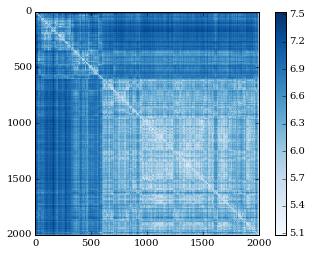

In [267]:
plt.imshow(np.log(weighted_rmsd),cmap='Blues',interpolation='none')
plt.colorbar()

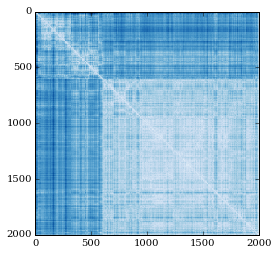

In [272]:
plt.imshow(np.log(rmsd[:2000,:2000]+10),cmap='Blues',interpolation='none')

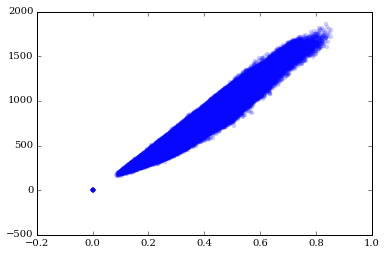

In [277]:
plt.scatter(rmsd[:2000,:2000].flatten(),weighted_rmsd.flatten(),alpha=0.1,linewidths=0)

In [241]:
from numpy.linalg import det
def BC(X,Y):
    return det(X.T.dot(Y)) / np.sqrt(det(X.T.dot(X)) * det(Y.T.dot(Y)))

def BC_w(X,Y,M=None):
    if M==None:
        M = np.diag(np.ones(len(X)))
        
    return det(X.T.dot(M).dot(Y)) / np.sqrt(det(X.T.dot(M).dot(X)) * det(Y.T.dot(M).dot(Y)))

In [284]:
n

2000

In [286]:
%%prun
bc_mat = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        bc_mat[i,j] = BC(rpft[i],rpft[j])
    if i % 100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
 

In [289]:
wbc_mat = np.zeros((n,n))
weight_matrix = np.diag(weights)
for i in range(n):
    for j in range(i):
        wbc_mat[i,j] = BC_w(rpft[i],rpft[j],weight_matrix)
    if i % 100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


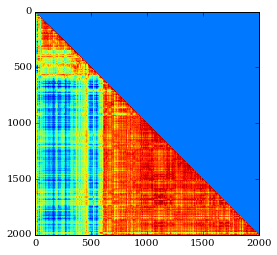

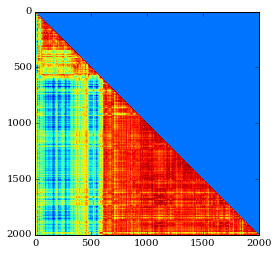

In [314]:
plt.imshow(bc_mat)
plt.figure()
plt.imshow(wbc_mat)

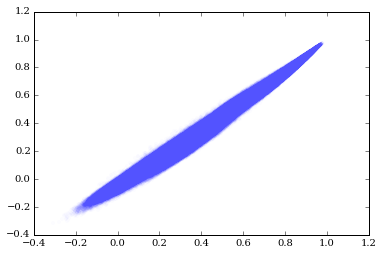

In [293]:

plt.scatter(wbc_mat.flatten(),bc_mat.flatten(),alpha=0.01,linewidths=0)

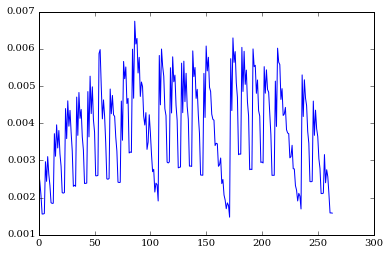

In [309]:
plt.plot(weights)

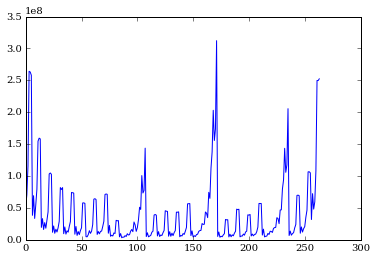

In [301]:
plt.plot(weights**-3)

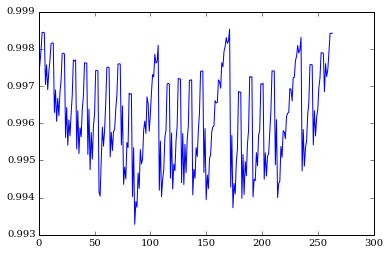

In [308]:
plt.plot(np.exp(-weights))

In [246]:
%prun BC(t[0].xyz[0],t[1].xyz[0])

In [240]:
%prun [compute_atomwise_deviation_xyz(t[0].xyz[0],t[1].xyz[0]) for i in range(1000)]

In [239]:
t[0].xyz[0]

array([[ 1.11600006, -1.08800006,  1.04900002],
       [ 1.13700008, -0.96800005,  1.028     ],
       [ 1.05200005, -1.12600005,  1.18000007],
       [ 1.01600003, -1.03800011,  1.23200011],
       [ 0.97300005, -1.20000005,  1.16300011],
       [ 1.12100005, -1.18000007,  1.24600005],
       [ 1.12800002, -1.18200004,  0.95800006],
       [ 1.13200009, -1.27800012,  0.98900002],
       [ 1.22500002, -1.15900004,  0.83800006],
       [ 1.31500006, -1.10600007,  0.86900002],
       [ 1.2750001 , -1.29900002,  0.79700005],
       [ 1.32800007, -1.34100008,  0.88200003],
       [ 1.34800005, -1.27900004,  0.71900004],
       [ 1.18800008, -1.36100006,  0.77300006],
       [ 1.15900004, -1.07600009,  0.72700006],
       [ 1.22800004, -0.99300003,  0.66300005],
       [ 1.02900004, -1.10900009,  0.70700002],
       [ 0.97500002, -1.1730001 ,  0.76300001],
       [ 0.95600003, -1.06400001,  0.58700001],
       [ 1.01800001, -1.0660001 ,  0.49800003],
       [ 0.84000003, -1.16500008,  0.571

In [188]:
weights.shape

(12,)

In [ ]:
mini_medoids = MiniBatchKMedoids(metric=RMSD)

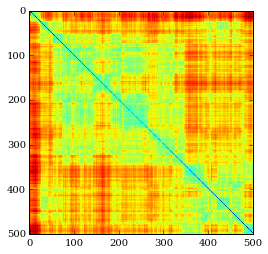

In [313]:
plt.imshow(wrmsd_subset)

In [151]:
from sklearn.cluster import MiniBatchKMeans,

In [ ]:
kmeans = MiniBatchKMeans(